In [1]:
import pandas as pd

# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')
products = pd.read_csv('/content/Products.csv')

# Display the first few rows of each dataset to understand their structure
customers_head = customers.head()
transactions_head = transactions.head()
products_head = products.head()

customers_head, transactions_head, products_head


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

In [2]:
# Merge transactions with products to include product details
transactions_products = pd.merge(transactions, products, on='ProductID', how='left')

# Merge the resulting dataset with customers to include customer details
customer_data = pd.merge(transactions_products, customers, on='CustomerID', how='left')

# Aggregate transaction data at the customer level
customer_summary = customer_data.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    total_transactions=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    total_quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
    unique_categories=pd.NamedAgg(column='Category', aggfunc=lambda x: x.nunique()),
    unique_products=pd.NamedAgg(column='ProductID', aggfunc=lambda x: x.nunique())
).reset_index()

# Add region and signup date from the customers dataset
customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region', 'SignupDate']], on='CustomerID', how='left')

# Convert SignupDate to datetime
customer_summary['SignupDate'] = pd.to_datetime(customer_summary['SignupDate'])

# Display the aggregated data
customer_summary.head()


,CustomerID,total_spent,total_transactions,total_quantity,unique_categories,unique_products,Region,SignupDate
0,C0001,3354.52,5,12,3,5,South America,2022-07-10
1,C0002,1862.74,4,10,2,4,Asia,2022-02-13
2,C0003,2725.38,4,14,3,4,South America,2024-03-07
3,C0004,5354.88,8,23,3,8,South America,2022-10-09
4,C0005,2034.24,3,7,2,3,Asia,2022-08-15


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Select relevant features for clustering
features = customer_summary[['total_spent', 'total_transactions', 'total_quantity', 'unique_categories', 'unique_products', 'Region']]

# Preprocessing: Standardize numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['total_spent', 'total_transactions', 'total_quantity', 'unique_categories', 'unique_products']),
        ('cat', OneHotEncoder(), ['Region'])
    ]
)

# Apply preprocessing
processed_features = preprocessor.fit_transform(features)

# Apply clustering with KMeans for a range of cluster numbers
db_scores = []
k_values = range(2, 11)  # Number of clusters from 2 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(processed_features)
    db_index = davies_bouldin_score(processed_features, clusters)
    db_scores.append((k, db_index))

# Find the optimal number of clusters based on the lowest DB index
optimal_k, optimal_db_index = min(db_scores, key=lambda x: x[1])

db_scores, optimal_k, optimal_db_index


([(2, 0.9954270489493265),
  (3, 1.1439487002221056),
  (4, 1.3475152966945267),
  (5, 1.416875923911443),
  (6, 1.513445904848054),
  (7, 1.6274733208795928),
  (8, 1.5111917742426972),
  (9, 1.5428803237592088),
  (10, 1.6158918444271315)],
 2,
 0.9954270489493265)

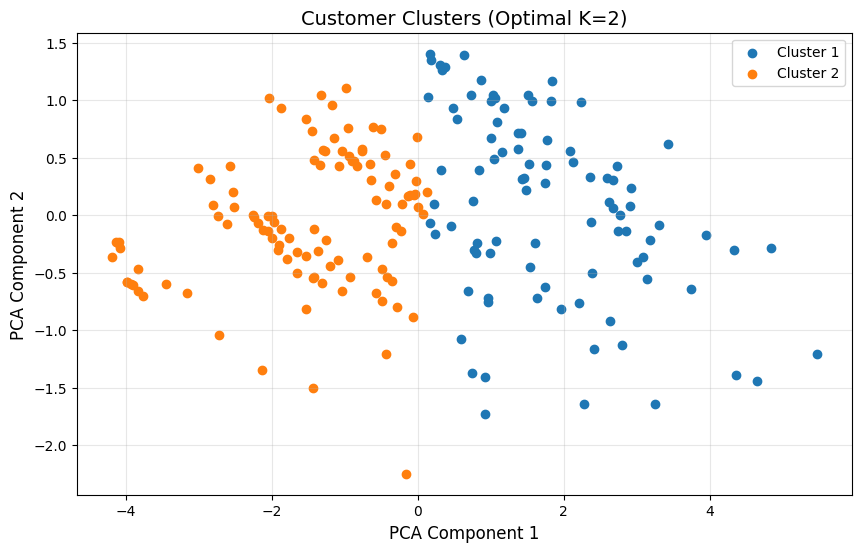

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(processed_features)

# Reduce dimensions using PCA for visualization (2D)
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(processed_features)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(reduced_features[clusters_optimal == cluster, 0],
                reduced_features[clusters_optimal == cluster, 1],
                label=f'Cluster {cluster+1}')

plt.title("Customer Clusters (Optimal K=2)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()
